# TP3 - Deep Learning : Méthodologie, Expérimentations et Régularisation 

<p style="font-weight: bold; font-size: 16px;"><span style="color: red;">Auteur : </span>TOURE Boubacar (<a href="boubacar.toure@etud.univ-angers.fr">boubacar.toure@etud.univ-angers.fr</a>), étudiant en Master 2 Informatique à la faculté des sciences d'Angers</p>
<p style="font-weight: bold; font-size: 16px;"><span style="color: red;">Professeur Référent : </span>Sylvain Lamprier (<a href="sylvain.lamprier@univ-angers.fr">sylvain.lamprier@univ-angers.fr</a>)</p>

Supports adaptés de Nicolas Baskiotis (<a href="nicolas.baskiotis@sorbonne-univeriste.fr">nicolas.baskiotis@sorbonne-univeriste.fr</a>) et Benjamin Piwowarski (<a href="benjamin.piwowarski@sorbonne-universite.fr">benjamin.piwowarski@sorbonne-universite.fr</a>) -- MLIA/ISIR, Sorbonne Université

# Import du projet

In [3]:
import matplotlib.pyplot as plt
import torch.nn as nn
import shutil
import torch
import time
import os

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

from tqdm.autonotebook import tqdm
from tqdm import tqdm

ModuleNotFoundError: No module named 'torch'

# Déclaration des fonctions 

In [36]:
def save_state(fichier,epoch,model,optim):
    state = {'epoch' : epoch, 'model_state': model.state_dict(), 'optim_state': optim.state_dict()}
    torch.save(state,fichier)

def load_state(fichier,model,optim):
    epoch = 0
    if os.path.isfile(fichier):
        state = torch.load(fichier)
        model.load_state_dict(state['model_state'])
        optim.load_state_dict(state['optim_state'])
        epoch = state['epoch']
    return epoch

def unnormalize(img, mean, std):
    if img.dim()==2 or ((img.dim()==3) and (img.size()[0]==1)):
        return img*std[0]+mean[0]
    return img * img.new(std).view(3, 1, 1) + img.new(mean).view(3, 1, 1)

# requiert que les modules soient enregistrés dans une liste model.hidden_layers
def addWeightsHisto(writer,model,epoch):                
    ix = 0
    for module in model.hidden_layers:
        if isinstance(module, nn.Linear):
            writer.add_histogram(f'Linear/{ix}/weight', module.weight, epoch)
            ix += 1

def train(model, train_loader, validation_loader, loss_fn, optimizer, epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    loss_fn = loss_fn.to(device)
    
    # Clear any logs from previous runs
    if os.path.exists(f"/tmp/logs/deepLearning/{model.name}-train"):
        shutil.rmtree(f"/tmp/logs/deepLearning/{model.name}-train")
        os.remove(f"/tmp/models/{model.name}-train.pth")
    
    # On créé un writer avec la date du modèle pour s'y retrouver
    TB_PATH = f"/tmp/logs/deepLearning"
    MODEL_PATH = "/tmp/models/"
    os.makedirs(MODEL_PATH, exist_ok=True)
    check_file = f"{MODEL_PATH}/{model.name}-train.pth"
    
    summary = SummaryWriter(f"{TB_PATH}/{model.name}-train")
    
    train_losses = []
    validation_losses = []
    
    start_epoch = load_state(check_file, model, optimizer)
    
    start_time = time.time()
    for epoch in range(start_epoch, epochs+1):
        # Entraînement sur les données d'entraînement
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        summary.add_scalar("Loss_Of_Train", train_loss/len(train_loader), epoch)
        train_losses.append(train_loss/len(train_loader))
            
        if epoch % 10 == 0: 
            # Evaluation sur les données de test
            save_state(check_file, epoch, model, optimizer)
            model.eval()
            with torch.no_grad():
                validation_loss = 0
                correct = 0
                total = 0
                for inputs, labels in validation_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    validation_loss += loss_fn(outputs, labels).item()
            
            accuracy = correct / total
            summary.add_scalar("Accuracy", accuracy, epoch)
            summary.add_scalar("Loss_Of_Validation", validation_loss/len(validation_loader), epoch)
            validation_losses.append(validation_loss/len(validation_loader))
            
            print("\tEpoch {}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, validation_loss, accuracy))
        else:
            print("Epoch {}, Train Loss: {:.4f}".format(epoch, train_loss/len(train_loader)))
    end_time = time.time()
    
    trainTime = end_time - start_time
    trainModelComplexity = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    plt.figure
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(validation_losses)
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    # Load the TensorBoard notebook extension
    %load_ext tensorboard
    %tensorboard --logdir {TB_PATH}/{model.name}-train
    
    return trainTime, trainModelComplexity, validation_loss, accuracy

def set_dropout_rate(m, rate):
    if type(m) == nn.Dropout:
        m.p = rate

def train_dropout(model, train_loader, validation_loader, loss_fn, optimizer, epochs, dropout_rate):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    loss_fn = loss_fn.to(device)
    
    # Clear any logs from previous runs
    if os.path.exists(f"/tmp/logs/deepLearning/{model.name}-train_dropout"):
        shutil.rmtree(f"/tmp/logs/deepLearning/{model.name}-train_dropout")
    
    # On créé un writer avec la date du modèle pour s'y retrouver
    TB_PATH = f"/tmp/logs/deepLearning"
    MODEL_PATH = "/tmp/models/"
    os.makedirs(MODEL_PATH, exist_ok=True)
    check_file = f"{MODEL_PATH}/{model.name}-train_dropout.pth"
    
    summary = SummaryWriter(f"{TB_PATH}/{model.name}-train_dropout")
    
    train_losses = []
    validation_losses = []
    
    start_epoch = load_state(check_file, model, optimizer)
    
    start_time = time.time()
    for epoch in range(start_epoch, epochs+1):
        # Entraînement sur les données d'entraînement
        model.train()
        model.apply(lambda x: set_dropout_rate(x, dropout_rate))
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        summary.add_scalar("Loss_Of_Train", train_loss/len(train_loader), epoch)
        train_losses.append(train_loss/len(train_loader))
            
        if epoch % 10 == 0: 
            # Evaluation sur les données de test
            model.eval()
            model.apply(lambda x: set_dropout_rate(x, 0))
            with torch.no_grad():
                validation_loss = 0
                correct = 0
                total = 0
                for inputs, labels in validation_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    validation_loss += loss_fn(outputs, labels).item()
            
            accuracy = correct / total
            summary.add_scalar("Accuracy", accuracy, epoch)
            summary.add_scalar("Loss_Of_Validation", validation_loss/len(validation_loader), epoch)
            validation_losses.append(validation_loss/len(validation_loader))
            
            print("\tEpoch {}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, validation_loss, accuracy))
        else:
            print("Epoch {}, Train Loss: {:.4f}".format(epoch, train_loss/len(train_loader)))
    end_time = time.time()
    trainTime = end_time - start_time
    
    trainModelComplexity = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    plt.figure
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(validation_losses)
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    # Load the TensorBoard notebook extension
    %load_ext tensorboard
    %tensorboard --logdir {TB_PATH}/{model.name}-train_dropout
    
    return trainTime, trainModelComplexity, validation_loss, accuracy

def train_batchnorm(model, train_loader, validation_loader, loss_fn, optimizer, epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    loss_fn = loss_fn.to(device)
    
    # Clear any logs from previous runs
    if os.path.exists(f"/tmp/logs/deepLearning/{model.name}-train_batchnorm"):
        shutil.rmtree(f"/tmp/logs/deepLearning/{model.name}-train_batchnorm")

    # On créé un writer avec la date du modèle pour s'y retrouver
    TB_PATH = f"/tmp/logs/deepLearning"
    MODEL_PATH = "/tmp/models/"
    os.makedirs(MODEL_PATH, exist_ok=True)
    check_file = f"{MODEL_PATH}/{model.name}-train_batchnorm.pth"

    summary = SummaryWriter(f"{TB_PATH}/{model.name}-train_batchnorm")

    train_losses = []
    validation_losses = []

    start_epoch = load_state(check_file, model, optimizer)
    
    start_time = time.time()
    for epoch in range(start_epoch, epochs+1):
        # Entraînement sur les données d'entraînement
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        summary.add_scalar("Loss_Of_Train", train_loss/len(train_loader), epoch)
        train_losses.append(train_loss/len(train_loader))

        if epoch % 10 == 0: 
            # Evaluation sur les données de test
            model.eval()
            with torch.no_grad():
                validation_loss = 0
                correct = 0
                total = 0
                for inputs, labels in validation_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    validation_loss += loss_fn(outputs, labels).item()
            
            accuracy = correct / total
            summary.add_scalar("Accuracy", accuracy, epoch)
            summary.add_scalar("Loss_Of_Validation", validation_loss/len(validation_loader), epoch)
            validation_losses.append(validation_loss/len(validation_loader))

            print("\tEpoch {}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, validation_loss, accuracy))
        else:
            print("Epoch {}, Train Loss: {:.4f}".format(epoch, train_loss/len(train_loader)))
    end_time = time.time()
    trainTime = end_time - start_time
    
    trainModelComplexity = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    plt.figure
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(validation_losses)
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    # Load the TensorBoard notebook extension
    %load_ext tensorboard
    %tensorboard --logdir {TB_PATH}/{model.name}-train_batchnorm
    
    return trainTime, trainModelComplexity, validation_loss, accuracy

# Déclaration des class

In [4]:
class LinearMultiClass(nn.Module):
    def __init__(self, in_size, out_size, hidden_layers, final_activation=None, activation=nn.Tanh()):
        super(LinearMultiClass, self).__init__()
        self.name = "Linear_Multi_Class"
        self.in_size = in_size
        self.hidden_layers = nn.ModuleList()
        self.output_layer = nn.Linear(hidden_layers[-1], out_size)
        self.final_activation = final_activation
        self.activation = activation
        
        for i, h in enumerate(hidden_layers):
            self.hidden_layers.append(nn.Linear(in_size if i == 0 else hidden_layers[i-1], h))

    def forward(self, x):
        x = x.view(-1, self.in_size)
        for i, layer in enumerate(self.hidden_layers):
            x = layer(x)
            x = self.activation(x)

        x = self.output_layer(x)
        if self.final_activation is not None:
            x = self.final_activation(x)
        return x

class LinearMultiClassWithDropout(nn.Module):
    def __init__(self, in_size, out_size, hidden_layers, dropout_rate=0.5, final_activation=None, activation=nn.Tanh()):
        super(LinearMultiClassWithDropout, self).__init__()
        self.name = "Linear_Multi_Class_With_Dropout"
        self.in_size = in_size
        self.hidden_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        self.dropout_rate = dropout_rate
        self.output_layer = nn.Linear(hidden_layers[-1], out_size)
        self.final_activation = final_activation
        self.activation = activation
        
        for i, h in enumerate(hidden_layers):
            self.hidden_layers.append(nn.Linear(in_size if i == 0 else hidden_layers[i-1], h))
            self.dropout_layers.append(nn.Dropout(p=self.dropout_rate))

    def forward(self, x):
        x = x.view(-1, self.in_size)
        for i, layer in enumerate(self.hidden_layers):
            x = layer(x)
            x = self.activation(x)
            x = self.dropout_layers[i](x)

        x = self.output_layer(x)
        if self.final_activation is not None:
            x = self.final_activation(x)
        return x

class LinearMultiClassWithBatchNorm(nn.Module):
    def __init__(self, in_size, out_size, hidden_layers, final_activation=None, activation=nn.Tanh()):
        super(LinearMultiClassWithBatchNorm, self).__init__()
        self.name = "Linear_Multi_Class_With_BatchNorm"
        self.in_size = in_size
        self.hidden_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList()
        self.output_layer = nn.Linear(hidden_layers[-1], out_size)
        self.final_activation = final_activation
        self.activation = activation
        
        for i, h in enumerate(hidden_layers):
            self.hidden_layers.append(nn.Linear(in_size if i == 0 else hidden_layers[i-1], h))
            self.batch_norm_layers.append(nn.BatchNorm1d(h))

    def forward(self, x):
        x = x.view(-1, self.in_size)
        for i, layer in enumerate(self.hidden_layers):
            x = layer(x)
            x = self.batch_norm_layers[i](x)
            x = self.activation(x)

        x = self.output_layer(x)
        if self.final_activation is not None:
            x = self.final_activation(x)
        return x


# Déclaration des données du projet

In [5]:
#Transformations à appliquer sur le dataset (transformation des images en tenseurs et normalization pour obtenir des valeurs entre -1 et 1)
mean = [0.5]
std = [0.5]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Téléchargement des données (via le dataset specifique MNIST de pytorch)
mnist_train = MNIST('./data', train=True, transform=transform, download=True)
mnist_test = MNIST('./data', train=False, transform=transform, download=True)

batch_size = 64
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(mnist_test, batch_size=batch_size)

TB_PATH = f"/tmp/logs/deepLearning"
epoch = 100

in_size = 784
out_size = 10
hidden_layers = [100, 100, 100]

# Récuperation d'une image de notre batch de données

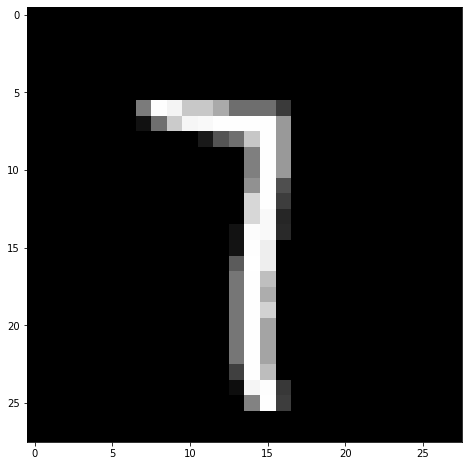

In [24]:
imgs,labs = next(iter(train_loader))

# dimension of images (flattened)reload_ext tensorboard
HEIGHT,WIDTH = imgs.shape[2], imgs.shape[3] # taille de l'image
INPUT_DIM = HEIGHT * WIDTH

#Visualisation de la première image
img = unnormalize(imgs[0], mean, std) # pour retrouver l'image d'origine (avant normalisation)
fig = plt.figure(figsize=(8, 8))

plt.imshow(img.squeeze(),cmap='Greys_r')

# Construction et Entrainement des modèles

## Modèle LinearMultiClass

	Epoch 0, Validation Loss: 188.2789
Epoch 1, Train Loss: 0.9557
Epoch 2, Train Loss: 0.6639
Epoch 3, Train Loss: 0.5240
Epoch 4, Train Loss: 0.4463
Epoch 5, Train Loss: 0.3982
Epoch 6, Train Loss: 0.3659
Epoch 7, Train Loss: 0.3423
Epoch 8, Train Loss: 0.3246
Epoch 9, Train Loss: 0.3103
	Epoch 10, Validation Loss: 44.7063
Epoch 11, Train Loss: 0.2877
Epoch 12, Train Loss: 0.2788
Epoch 13, Train Loss: 0.2704
Epoch 14, Train Loss: 0.2630
Epoch 15, Train Loss: 0.2563
Epoch 16, Train Loss: 0.2498
Epoch 17, Train Loss: 0.2438
Epoch 18, Train Loss: 0.2378
Epoch 19, Train Loss: 0.2323
	Epoch 20, Validation Loss: 34.9388
Epoch 21, Train Loss: 0.2216
Epoch 22, Train Loss: 0.2166
Epoch 23, Train Loss: 0.2121
Epoch 24, Train Loss: 0.2074
Epoch 25, Train Loss: 0.2028
Epoch 26, Train Loss: 0.1985
Epoch 27, Train Loss: 0.1942
Epoch 28, Train Loss: 0.1901
Epoch 29, Train Loss: 0.1861
	Epoch 30, Validation Loss: 28.6048
Epoch 31, Train Loss: 0.1784
Epoch 32, Train Loss: 0.1748
Epoch 33, Train Loss: 0.

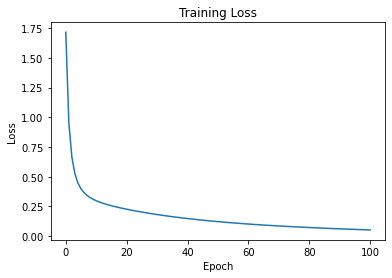

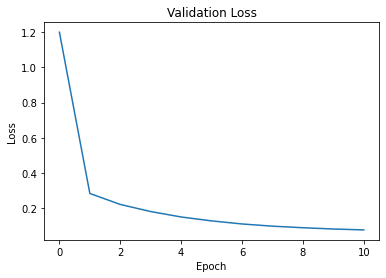

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 3895), started 0:23:59 ago. (Use '!kill 3895' to kill it.)

In [25]:
# Définir le modèle, la fonction de coût, et l'optimiseur
model = LinearMultiClass(in_size=784, out_size=10, hidden_layers=[256, 128], activation=nn.Tanh())
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=1e-5)

# Entraîner le modèle
modelLinearMultiClass_ExecutionTime, modelLinearMultiClass_Complexity, modelLinearMultiClass_validationLoss, modelLinearMultiClass_accuracy = train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100)

### Construction d'un histogramme avec les données du modèle

In [37]:
summary = SummaryWriter(f"{TB_PATH}/{model.name}-historigramme")
addWeightsHisto(summary, model, epoch)

# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir {TB_PATH}/{model.name}-historigramme

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Pénalisation des couches

#### Pour la norme L2 de 10^-5

_________________________________ LA NORME L2 DE 10^−5 _________________________________
	Epoch 0, Validation Loss: 340.2699
Epoch 1, Train Loss: 2.0643
Epoch 2, Train Loss: 1.7589
Epoch 3, Train Loss: 1.4128
Epoch 4, Train Loss: 1.1352
Epoch 5, Train Loss: 0.9306
Epoch 6, Train Loss: 0.7860
Epoch 7, Train Loss: 0.6864
Epoch 8, Train Loss: 0.6160
Epoch 9, Train Loss: 0.5638
	Epoch 10, Validation Loss: 77.1629
Epoch 11, Train Loss: 0.4917
Epoch 12, Train Loss: 0.4658
Epoch 13, Train Loss: 0.4440
Epoch 14, Train Loss: 0.4256
Epoch 15, Train Loss: 0.4097
Epoch 16, Train Loss: 0.3960
Epoch 17, Train Loss: 0.3838
Epoch 18, Train Loss: 0.3728
Epoch 19, Train Loss: 0.3632
	Epoch 20, Validation Loss: 53.3425
Epoch 21, Train Loss: 0.3461
Epoch 22, Train Loss: 0.3385
Epoch 23, Train Loss: 0.3318
Epoch 24, Train Loss: 0.3252
Epoch 25, Train Loss: 0.3191
Epoch 26, Train Loss: 0.3131
Epoch 27, Train Loss: 0.3076
Epoch 28, Train Loss: 0.3023
Epoch 29, Train Loss: 0.2973
	Epoch 30, Validation Loss: 4

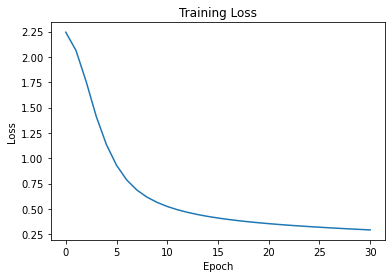

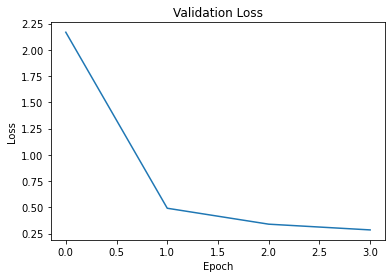

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 3895), started 0:49:07 ago. (Use '!kill 3895' to kill it.)

In [30]:
print("__________________LA NORME L2 DE 10^−5 __________________")
weight_decay = 10e-5
model = LinearMultiClass(in_size, out_size, hidden_layers, activation=nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=weight_decay)
train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=30)

#### Pour la norme L2 de 10^-4


_________________________________ LA NORME L2 DE 10^-4 _________________________________
	Epoch 0, Validation Loss: 337.5269
Epoch 1, Train Loss: 2.0284
Epoch 2, Train Loss: 1.6946
Epoch 3, Train Loss: 1.3632
Epoch 4, Train Loss: 1.1151
Epoch 5, Train Loss: 0.9348
Epoch 6, Train Loss: 0.8007
Epoch 7, Train Loss: 0.7003
Epoch 8, Train Loss: 0.6249
Epoch 9, Train Loss: 0.5680
	Epoch 10, Validation Loss: 77.3624
Epoch 11, Train Loss: 0.4909
Epoch 12, Train Loss: 0.4638
Epoch 13, Train Loss: 0.4417
Epoch 14, Train Loss: 0.4235
Epoch 15, Train Loss: 0.4075
Epoch 16, Train Loss: 0.3942
Epoch 17, Train Loss: 0.3823
Epoch 18, Train Loss: 0.3719
Epoch 19, Train Loss: 0.3627
	Epoch 20, Validation Loss: 53.3755
Epoch 21, Train Loss: 0.3466
Epoch 22, Train Loss: 0.3396
Epoch 23, Train Loss: 0.3331
Epoch 24, Train Loss: 0.3271
Epoch 25, Train Loss: 0.3214
Epoch 26, Train Loss: 0.3160
Epoch 27, Train Loss: 0.3111
Epoch 28, Train Loss: 0.3064
Epoch 29, Train Loss: 0.3017
	Epoch 30, Validation Loss: 

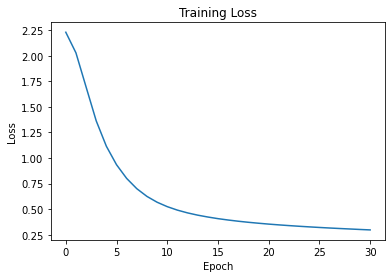

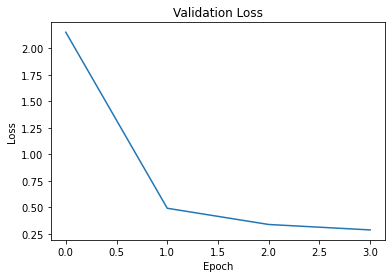

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 3895), started 0:55:08 ago. (Use '!kill 3895' to kill it.)

In [31]:
print("\n__________________LA NORME L2 DE 10^-4 __________________")
weight_decay = 10e-4
model = LinearMultiClass(in_size, out_size, hidden_layers, activation=nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=weight_decay)
train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=30)

#### Pour la norme L2 de 10^-3


_________________________________ LA NORME L2 DE 10^-3 _________________________________
	Epoch 0, Validation Loss: 331.7799
Epoch 1, Train Loss: 1.9832
Epoch 2, Train Loss: 1.6486
Epoch 3, Train Loss: 1.3334
Epoch 4, Train Loss: 1.1039
Epoch 5, Train Loss: 0.9445
Epoch 6, Train Loss: 0.8290
Epoch 7, Train Loss: 0.7414
Epoch 8, Train Loss: 0.6738
Epoch 9, Train Loss: 0.6214
	Epoch 10, Validation Loss: 86.0859
Epoch 11, Train Loss: 0.5478
Epoch 12, Train Loss: 0.5216
Epoch 13, Train Loss: 0.4996
Epoch 14, Train Loss: 0.4814
Epoch 15, Train Loss: 0.4657
Epoch 16, Train Loss: 0.4519
Epoch 17, Train Loss: 0.4400
Epoch 18, Train Loss: 0.4290
Epoch 19, Train Loss: 0.4194
	Epoch 20, Validation Loss: 61.9804
Epoch 21, Train Loss: 0.4028
Epoch 22, Train Loss: 0.3954
Epoch 23, Train Loss: 0.3887
Epoch 24, Train Loss: 0.3823
Epoch 25, Train Loss: 0.3766
Epoch 26, Train Loss: 0.3714
Epoch 27, Train Loss: 0.3662
Epoch 28, Train Loss: 0.3613
Epoch 29, Train Loss: 0.3570
	Epoch 30, Validation Loss: 

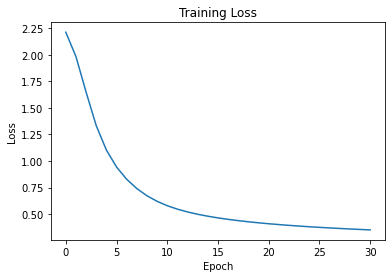

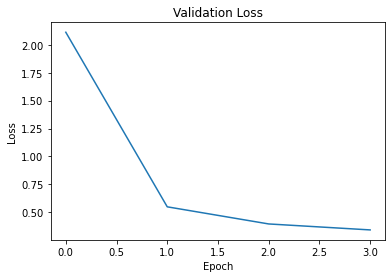

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 3895), started 1:00:32 ago. (Use '!kill 3895' to kill it.)

In [32]:
print("\n__________________LA NORME L2 DE 10^-3 __________________")
weight_decay = 10e-3
model = LinearMultiClass(in_size, out_size, hidden_layers, activation=nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=weight_decay)
train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=30)

#### Pour la norme L2 de 0


_________________________________ LA NORME L2 DE 0 _________________________________
	Epoch 0, Validation Loss: 335.5186
Epoch 1, Train Loss: 2.0151
Epoch 2, Train Loss: 1.6928
Epoch 3, Train Loss: 1.3557
Epoch 4, Train Loss: 1.0899
Epoch 5, Train Loss: 0.9013
Epoch 6, Train Loss: 0.7669
Epoch 7, Train Loss: 0.6708
Epoch 8, Train Loss: 0.6014
Epoch 9, Train Loss: 0.5502
	Epoch 10, Validation Loss: 75.2388
Epoch 11, Train Loss: 0.4795
Epoch 12, Train Loss: 0.4541
Epoch 13, Train Loss: 0.4331
Epoch 14, Train Loss: 0.4153
Epoch 15, Train Loss: 0.4000
Epoch 16, Train Loss: 0.3871
Epoch 17, Train Loss: 0.3755
Epoch 18, Train Loss: 0.3653
Epoch 19, Train Loss: 0.3561
	Epoch 20, Validation Loss: 52.3292
Epoch 21, Train Loss: 0.3403
Epoch 22, Train Loss: 0.3335
Epoch 23, Train Loss: 0.3270
Epoch 24, Train Loss: 0.3209
Epoch 25, Train Loss: 0.3153
Epoch 26, Train Loss: 0.3098
Epoch 27, Train Loss: 0.3048
Epoch 28, Train Loss: 0.2999
Epoch 29, Train Loss: 0.2954
	Epoch 30, Validation Loss: 44.4

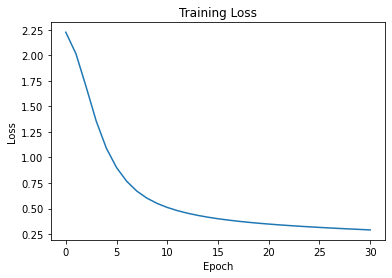

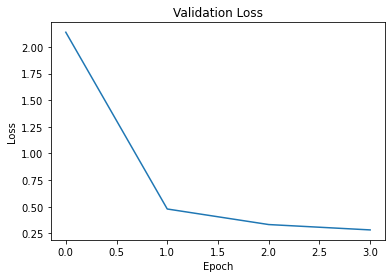

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 3895), started 1:05:49 ago. (Use '!kill 3895' to kill it.)

In [33]:
print("\n__________________LA NORME L2 DE 0 __________________")
weight_decay = 0
model = LinearMultiClass(in_size, out_size, hidden_layers, activation=nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=weight_decay)
train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=30)

## Modèle LinearMultiClassWithDropout

	Epoch 0, Validation Loss: 339.7960
Epoch 1, Train Loss: 2.0953
Epoch 2, Train Loss: 1.8706
Epoch 3, Train Loss: 1.6108
Epoch 4, Train Loss: 1.3829
Epoch 5, Train Loss: 1.2087
Epoch 6, Train Loss: 1.0763
Epoch 7, Train Loss: 0.9738
Epoch 8, Train Loss: 0.8932
Epoch 9, Train Loss: 0.8279
	Epoch 10, Validation Loss: 87.2910
Epoch 11, Train Loss: 0.7280
Epoch 12, Train Loss: 0.6954
Epoch 13, Train Loss: 0.6645
Epoch 14, Train Loss: 0.6418
Epoch 15, Train Loss: 0.6222
Epoch 16, Train Loss: 0.6027
Epoch 17, Train Loss: 0.5868
Epoch 18, Train Loss: 0.5742
Epoch 19, Train Loss: 0.5651
	Epoch 20, Validation Loss: 58.3586
Epoch 21, Train Loss: 0.5460
Epoch 22, Train Loss: 0.5371
Epoch 23, Train Loss: 0.5313
Epoch 24, Train Loss: 0.5225
Epoch 25, Train Loss: 0.5182
Epoch 26, Train Loss: 0.5052
Epoch 27, Train Loss: 0.5054
Epoch 28, Train Loss: 0.5004
Epoch 29, Train Loss: 0.4932
	Epoch 30, Validation Loss: 51.1170
Epoch 31, Train Loss: 0.4871
Epoch 32, Train Loss: 0.4783
Epoch 33, Train Loss: 0.

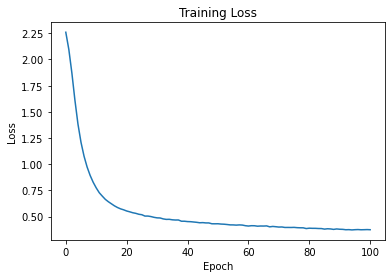

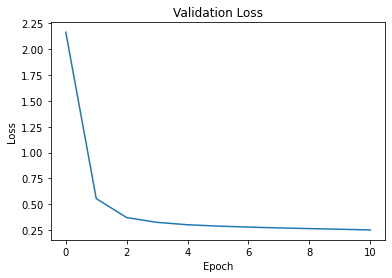

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [34]:
dropout_rate = 0.5
model = LinearMultiClassWithDropout(in_size, out_size, hidden_layers, dropout_rate)

# Define our loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Train the model Dropout
modelLinearMultiClassWithDropout_ExecutionTime, modelLinearMultiClassWithDropout_Complexity, modelLinearMultiClassWithDropout_validationLoss, modelLinearMultiClassWithDropout_accuracy = train_dropout(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, dropout_rate=dropout_rate)

## Modèle LinearMultiClassWithBatchNorm

<ipython-input-4-8096a4ae721a>:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activation(x)


	Epoch 0, Validation Loss: 134.0159
Epoch 1, Train Loss: 0.5517
Epoch 2, Train Loss: 0.2523
Epoch 3, Train Loss: 0.1600
Epoch 4, Train Loss: 0.1183
Epoch 5, Train Loss: 0.0919
Epoch 6, Train Loss: 0.0791
Epoch 7, Train Loss: 0.0655
Epoch 8, Train Loss: 0.0631
Epoch 9, Train Loss: 0.0488
	Epoch 10, Validation Loss: 11.4527
Epoch 11, Train Loss: 0.0455
Epoch 12, Train Loss: 0.0403
Epoch 13, Train Loss: 0.0371
Epoch 14, Train Loss: 0.0367
Epoch 15, Train Loss: 0.0317
Epoch 16, Train Loss: 0.0310
Epoch 17, Train Loss: 0.0286
Epoch 18, Train Loss: 0.0267
Epoch 19, Train Loss: 0.0266
	Epoch 20, Validation Loss: 12.6389
Epoch 21, Train Loss: 0.0233
Epoch 22, Train Loss: 0.0198
Epoch 23, Train Loss: 0.0198
Epoch 24, Train Loss: 0.0187
Epoch 25, Train Loss: 0.0175
Epoch 26, Train Loss: 0.0214
Epoch 27, Train Loss: 0.0188
Epoch 28, Train Loss: 0.0167
Epoch 29, Train Loss: 0.0165
	Epoch 30, Validation Loss: 13.2232
Epoch 31, Train Loss: 0.0142
Epoch 32, Train Loss: 0.0137
Epoch 33, Train Loss: 0.

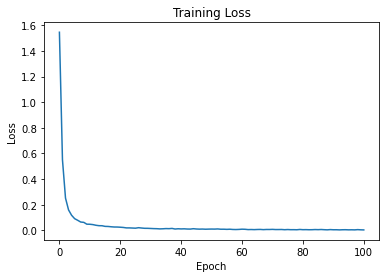

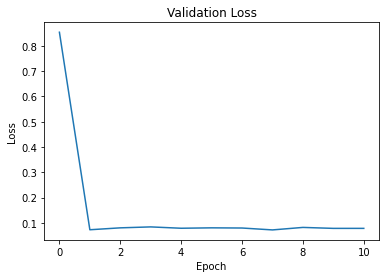

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [35]:
model = LinearMultiClassWithBatchNorm(in_size=784, out_size=10, hidden_layers=[256, 128, 64], activation=nn.Softmax())
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
modelLinearMultiClassWithBatchNorm_ExecutionTime, modelLinearMultiClassWithBatchNorm_Complexity, modelLinearMultiClassWithBatchNorm_validationLoss, modelLinearMultiClassWithBatchNorm_accuracy = train_batchnorm(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100)

# Fonction de comparaison des modèles 

Cette fonction renvoie maintenant des informations détaillées sur les deux modèles, y compris la perte, la précision, la complexité en termes de nombre de paramètres et le temps d'évaluation sur les données de validation. 

Pour comparer les performances d'un modèle sur des données de validation, il est plus pratique de comparer les moyennes des pertes de validation (validation_loss) calculées sur l'ensemble des données de validation pour chaque époque.

<span style="color: red;">N.B.</span> <span style="font-style: italic;">L'accuracy est un métrique couramment utilisé pour évaluer la performance d'un modèle de classification. C'est la proportion de prédictions correctes que le modèle fait par rapport au nombre total de prédictions. L'accuracy est généralement exprimée en pourcentage et peut être calculée en comparant les étiquettes prévues par le modèle avec les étiquettes réelles. Plus l'accuracy est élevée, meilleure est la performance du modèle.</span>

In [ ]:
def compare_models(executionTimeOfModel1, complexityOfModel1, validationLossOfModel1, accuracyOfModel1, executionTimeOfModel2, complexityOfModel2, validationLossOfModel2, accuracyOfModel2):
    print("Le modèle 1 a une perte de {} sur les données de validation avec une précision de {}% et une complexité de {} paramètres et un temps d'évaluation de {}s".format(validationLossOfModel1, accuracyOfModel1*100, complexityOfModel1, executionTimeOfModel1))
    print("Le modèle 2 a une perte de {} sur les données de validation avec une précision de {}% et une complexité de {} paramètres et un temps d'évaluation de {}s".format(validationLossOfModel2, accuracyOfModel2*100, complexityOfModel2, executionTimeOfModel2))

    if validationLossOfModel1 < validationLossOfModel2:
        print("\tLe modèle 1 a une perte plus faible sur les données de validation.")
        return 1
    else:
        print("\tLe modèle 2 a une perte plus faible sur les données de validation.")
        return 2

# Comparaison des données des modèles

## Pour : LinearMultiClass & LinearMultiClassWithDropout

In [2]:
resultTest1 = compare_models(modelLinearMultiClass_ExecutionTime, modelLinearMultiClass_Complexity, modelLinearMultiClass_validationLoss, modelLinearMultiClass_accuracy, modelLinearMultiClassWithDropout_ExecutionTime, modelLinearMultiClassWithDropout_Complexity, modelLinearMultiClassWithDropout_validationLoss, modelLinearMultiClassWithDropout_accuracy)

if resultTest1 == 1:
    print("\n_________________\nLe Modèle LinearMultiClass est le plus performant !\n_________________\n")
else:
    print("\n_________________\nLe Modèle LinearMultiClassWithDropout est le plus performant !\n_________________\n")

NameError: name 'compare_models' is not defined

## Pour : LinearMultiClass & LinearMultiClassWithBatchNorm

In [ ]:
resultTest2 = compare_models(modelLinearMultiClass_ExecutionTime, modelLinearMultiClass_Complexity, modelLinearMultiClass_validationLoss, modelLinearMultiClass_accuracy, modelLinearMultiClassWithBatchNorm_ExecutionTime, modelLinearMultiClassWithBatchNorm_Complexity, modelLinearMultiClassWithBatchNorm_validationLoss, modelLinearMultiClassWithBatchNorm_accuracy)

if resultTest2 == 1:
    print("\n_________________\nLe Modèle LinearMultiClass est le plus performant !\n_________________\n")
else:
    print("\n_________________\nLe Modèle LinearMultiClassWithBatchNorm est le plus performant !\n_________________\n")

## Pour : LinearMultiClassWithDropout & LinearMultiClassWithBatchNorm

In [ ]:
resultTest3 = compare_models(modelLinearMultiClassWithDropout_ExecutionTime, modelLinearMultiClassWithDropout_Complexity, modelLinearMultiClassWithDropout_validationLoss, modelLinearMultiClassWithDropout_accuracy, modelLinearMultiClassWithBatchNorm_ExecutionTime, modelLinearMultiClassWithBatchNorm_Complexity, modelLinearMultiClassWithBatchNorm_validationLoss, modelLinearMultiClassWithBatchNorm_accuracy)

if resultTest2 == 1:
    print("\n_________________\nLe Modèle LinearMultiClassWithDropout est le plus performant !\n_________________\n")
else:
    print("\n_________________\nLe Modèle LinearMultiClassWithBatchNorm est le plus performant !\n_________________\n")

# Conclusion
<span style="color: #09F72B;"> Nous pouvons donc conclure que le modèle <span style="color:#096DF7;">xxx</span> est le plus performant des trois (3) modèles que nous avons eu à étudier avec nos jeux de données.</span>